In [ ]:
# 라이브러리 import
import os
import numpy as np
import math
import matplotlib.pyplot as plt

import torchvision.utils as utils
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision import datasets

from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F


In [ ]:
# 데이터 셋 로드
image_size = 64
dataset = datasets.CIFAR10(root='data', download = True,
                           transform = transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]))
"""
Args:
    image_size (int): Size to which the images are resized. Here, 64x64 pixels.
    root (str): Directory where the CIFAR-10 dataset will be downloaded.
    download (bool): If True, downloads the dataset if not already present.
    transform (Compose): Sequence of transformations applied to the dataset images:
        - Resize to image_size.
        - Center crop to ensure consistent dimensions.
        - Convert images to tensor format.
        - Normalize pixel values to range [-1, 1].

Returns:
    torchvision.datasets.CIFAR10: Loaded CIFAR-10 dataset.

Example:
    >>> dataset = datasets.CIFAR10(root='data', download=True, transform=transform)
    >>> print(len(dataset))  # 60000 (50,000 training + 10,000 test samples)
"""

100%|██████████| 170M/170M [00:01<00:00, 93.2MB/s]


Extracting data/cifar-10-python.tar.gz to data


In [ ]:
# 학습 하이퍼파라미터 선언
n_epochs = 5
batch_size = 128
lr = 0.0002
b1 = 0.5
b2 = 0.999
latent_dim = 100
channels = 1
sample_interval = 400
device = torch.device("cuda" if(torch.cuda.is_available()) else "cpu")

In [ ]:
# 데이터 loader
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle=True)

"""
Create a DataLoader for the dataset.

Args:
    dataset (torch.utils.data.Dataset): The CIFAR-10 dataset loaded earlier.
    batch_size (int): Number of samples per batch. Here, 128.
    shuffle (bool): If True, shuffles the dataset each epoch.

Returns:
    torch.utils.data.DataLoader: DataLoader object for efficient data loading during training.

Example:
    >>> dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)
    >>> for batch in dataloader:
    >>>     images, labels = batch
    >>>     print(images.shape)  # torch.Size([128, 3, 64, 64])
"""

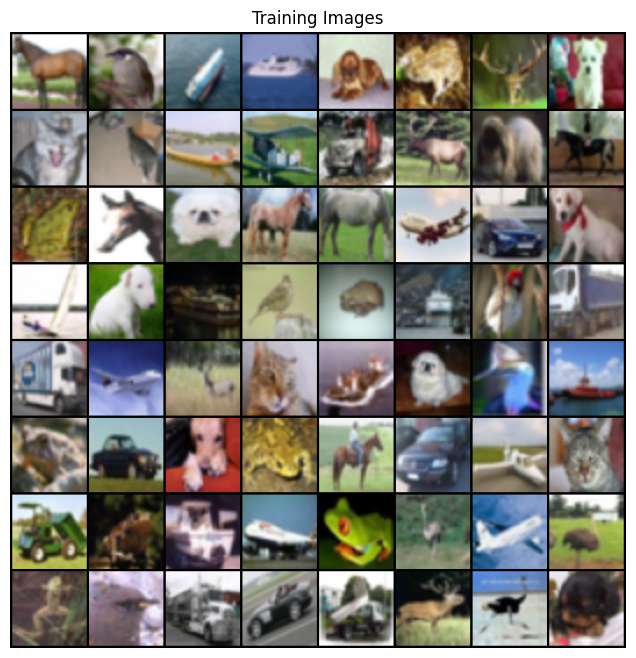

In [ ]:
# 데이터 탐색
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64],
                                        padding=2, normalize=True).cpu(), (1, 2, 0)))

"""
Visualize a batch of training images.

Args:
    real_batch (iterable): A batch of images fetched from the DataLoader.
    device (torch.device): Device to which the images are moved (CPU/GPU).

Returns:
    None: Displays the grid of training images using matplotlib.

Example:
    >>> real_batch = next(iter(dataloader))
    >>> plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))
"""

In [ ]:
# 가중치 초기화
def weights_init(w):
  """
  Initialize weights for layers in the generator and discriminator models.

  Args:
      w (nn.Module): A layer of the neural network.

  Returns:
      None: Updates the weights of the layer in-place.

  Example:
      >>> generator.apply(weights_init)
      >>> discriminator.apply(weights_init)
  """

  classname = w.__class__.__name__
  if classname.find('conv') != -1:
    nn.init.normal_(w.weight.data, 0.0, 0.02)
  elif classname.find('bn') != -1:
    nn.init.normal_(w.weight.data, 1.0, 0.02)
    nn.init.constant_(w.bias.data, 0)

In [ ]:
# Generator 함수
class Generator(nn.Module):
  """
  Generator for DCGAN

  Args:
      None: This class doesn;t take any arguments during initialization.

  Returns:
      torch.Tensor: Generated images of shape(batch_size, 3, image_size, image_size), where the number of channels is 3 for RGB images.

  Example:
      >>> generator = Generator()
      >>> noise = torch.randn(64, 100, 1, 1)
      >>> generated_images = generator(noise)
      >>> print(generated_images.shape) # torch.size([16, 3, 64, 64])
  """

  def __init__(self):
    super().__init__()
    self.tconv1 = nn.ConvTranspose2d(100, 64*8, kernel_size=4, stride=1, padding=0, bias=False)
    self.bn1 = nn.BatchNorm2d(64*8)
    self.tconv2 = nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1, bias=False)
    self.bn2 = nn.BatchNorm2d(64*4)
    self.tconv3 = nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1, bias=False)
    self.bn3 = nn.BatchNorm2d(64*2)
    self.tconv4 = nn.ConvTranspose2d(64*2, 64, 4, 2, 1, bias=False)
    self.bn4 = nn.BatchNorm2d(64)
    self.tconv5 = nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False)

  def forward(self, x):
    """
    Forward pass of the generator.

    Args:
        x (torch.Tensor): Input latent vector of shape (batch_size, 100, 1, 1).

    Returns:
        torch.Tensor: Generated images.
    """

    x = F.relu(self.bn1(self.tconv1(x)))
    x = F.relu(self.bn2(self.tconv2(x)))
    x = F.relu(self.bn3(self.tconv3(x)))
    x = F.relu(self.bn4(self.tconv4(x)))
    x = F.tanh(self.tconv5(x))

    return x

In [ ]:
# Discriminator 함수
class Discriminator(nn.Module):
  """
  Discriminator for DCGAN.

  Args:
      None: This class doesn't take any arguments during initialization. It defines its architecture internally.

  Returns:
      torch.Tensor: Validity scores of shape (batch_size, 1), indicating whether the input images are real or fake.

  Example:
      >>> discriminator = Discriminator()
      >>> images = torch.randn(16, 3, 64, 64)  # Batch of images with RGB channels
      >>> validity = discriminator(images)
      >>> print(validity.shape)  # torch.Size([16, 1])
  """

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 64, 4, 2, 1, bias=False)
    self.conv2 = nn.Conv2d(64, 64*2, 4, 2, 1, bias=False)
    self.bn2 = nn.BatchNorm2d(64*2)
    self.conv3 = nn.Conv2d(64*2, 64*4, 4, 2, 1, bias=False)
    self.bn3 = nn.BatchNorm2d(64*4)
    self.conv4 = nn.Conv2d(64*4, 64*8, 4, 2, 1, bias=False)
    self.bn4 = nn.BatchNorm2d(64*8)
    self.conv5 = nn.Conv2d(64*8, 1, 4, 1, 0, bias=False)

  def forward(self, x):
    """
    Forward pass of the discriminator.

    Args:
        x (torch.Tensor): Input images of shape (batch_size, 3, image_size, image_size).

    Returns:
        torch.Tensor: Validity scores.
    """

    x = F.leaky_relu(self.conv1(x), 0.2, True)
    x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2, True)
    x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2, True)
    x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2, True)
    x = F.sigmoid(self.conv5(x))

    return x

In [ ]:
# 모델 생성
generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator.apply(weights_init)
discriminator.apply(weights_init)

print(generator)
print(discriminator)

"""
Instantiate and initialize the Generator and Discriminator models.

Args:
    generator (Generator): Instance of the Generator class.
    discriminator (Discriminator): Instance of the Discriminator class.
    device (torch.device): Device on which the models are loaded (CPU/GPU).

Returns:
    None: The models are initialized and moved to the specified device.

Example:
    >>> generator = Generator().to(device)
    >>> discriminator = Discriminator().to(device)
    >>> generator.apply(weights_init)
    >>> discriminator.apply(weights_init)
"""

Generator(
  (tconv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)
Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(

In [ ]:
# 모델 컴파일
# Loss Function
adversarial_loss = nn.BCELoss()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# label / random noise 고정
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

real_label = 1.
fake_label = 0.

"""
Set up loss function, optimizers, and fixed noise for model training.

Args:
    adversarial_loss (nn.BCELoss): Binary Cross-Entropy loss used to train the discriminator and generator.
    optimizer_G (torch.optim.Adam): Adam optimizer for the Generator with specified learning rate and betas.
    optimizer_D (torch.optim.Adam): Adam optimizer for the Discriminator with specified learning rate and betas.
    fixed_noise (torch.Tensor): A fixed random noise tensor used to generate sample images during training for visualization.
    real_label (float): Label for real images (used in the Discriminator).
    fake_label (float): Label for generated images (used in the Discriminator).

Returns:
    None: Sets up the components for training but does not return any values directly.
"""

In [ ]:
# 모델 학습
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(n_epochs):
  for i, data in enumerate(dataloader, 0):
    """
    Train the GAN by iterating through the dataset, updating both the Generator and Discriminator.

    Args:
        epoch (int): Current epoch number.
        i (int): Current iteration within the epoch.
        real_img (torch.Tensor): Real images from the dataset.
        b_size (int): Batch size, representing the number of samples in a batch.
        noise (torch.Tensor): Random noise used as input to the Generator.
        fake (torch.Tensor): Generated images produced by the Generator.
        disc_loss (float): Total loss for the Discriminator, summing real and fake losses.
        gen_loss (float): Loss for the Generator.
        D_x (float): Mean output of the Discriminator for real images (D(x)).
        D_G_z1 (float): Mean output of the Discriminator for generated images before updating the Generator (D(G(z)) at step 1).
        D_G_z2 (float): Mean output of the Discriminator for generated images after updating the Generator (D(G(z)) at step 2).
        img_list (list): List for storing generated images at specific intervals for visualization.
        G_losses (list): List for storing the Generator losses during training.
        D_losses (list): List for storing the Discriminator losses during training.
        iters (int): Iteration counter used for tracking and controlling the image generation interval.

    Returns:
        None: This function trains the model and prints loss values, storing generated images periodically.
    """

    # Discriminator 학습
    real_img = data[0].to(device)
    b_size = real_img.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

    discriminator.zero_grad()
    output = discriminator(real_img).view(-1)
    real_loss = adversarial_loss(output, label)
    real_loss.backward()
    D_x = output.mean().item()

    noise = torch.randn(b_size, 100, 1, 1, device=device)
    fake = generator(noise)
    label.fill_(fake_label)

    output = discriminator(fake.detach()).view(-1)
    fake_loss = adversarial_loss(output, label)
    fake_loss.backward()

    D_G_z1 = output.mean().item()
    disc_loss = real_loss + fake_loss

    optimizer_D.step()

    # Generator 학습
    generator.zero_grad()
    label.fill_(real_label)
    output = discriminator(fake).view(-1)
    gen_loss = adversarial_loss(output, label)
    gen_loss.backward()
    D_G_z2 = output.mean().item()
    optimizer_G.step()

    """
    Generator Loss:
        - The loss is the Binary Cross-Entropy loss between the Discriminator's output for the generated images and the target label '1'.
        - The Generator loss encourages it to produce images that are more likely to be classified as real by the Discriminator.
    Discriminator Loss:
        - The total loss is the sum of:
            - 'real_loss': Binary Cross-Entropy loss for real images.
            - 'fake_loss': Binary Cross-Entropy loss for generated images.
        - The Discriminator loss encourages it to output a high value for real images and a low value for fake images.
    """

    if i % 50 == 0:
      print('[{}/{}][{}/{}]'.format(epoch+1, n_epochs, i, len(dataloader)))
      print('Discriminator Loss: {:.4f}\t Generator Loss:{:.4f}\t D(x):{:.4f}\t D(G(z)):{:.4f}/{:.4f}'.format(disc_loss.item(), gen_loss.item(), D_x, D_G_z1, D_G_z2))

      G_losses.append(gen_loss.item())
      D_losses.append(disc_loss.item())

      if (iters % 500 == 0) or ((epoch == n_epochs-1) and (i == len(dataloader)-1)):
        with torch.no_grad():
          fake = generator(fixed_noise).detach().cpu()
        img_list.append(utils.make_grid(fake, padding=2, normalize=True))

      iters += 1

      """
      About Result:
      - D(x)
          - D(x) is close to 0, Discriminator classifies real image as fake image,
          - D(x) is close to 1, Discriminator classifies real image as real image.
      - D(G(z))
          - D(G(z)) is close to 0, Generator is generating more realistic image and
                                   Discriminator is classifying well.
      """


[1/5][0/391]
Discriminator Loss: 1.3577	 Generator Loss:3.7340	 D(x):0.5431	 D(G(z)):0.5102/0.0251
[1/5][50/391]
Discriminator Loss: 0.5503	 Generator Loss:16.0968	 D(x):0.7064	 D(G(z)):0.0000/0.0000
[1/5][100/391]
Discriminator Loss: 1.1573	 Generator Loss:1.0467	 D(x):0.3823	 D(G(z)):0.0186/0.3989
[1/5][150/391]
Discriminator Loss: 0.2563	 Generator Loss:3.9448	 D(x):0.8550	 D(G(z)):0.0761/0.0229
[1/5][200/391]
Discriminator Loss: 0.0833	 Generator Loss:6.2387	 D(x):0.9610	 D(G(z)):0.0362/0.0021
[1/5][250/391]
Discriminator Loss: 1.5348	 Generator Loss:7.5249	 D(x):0.3315	 D(G(z)):0.0007/0.0016
[1/5][300/391]
Discriminator Loss: 0.5156	 Generator Loss:2.6989	 D(x):0.7481	 D(G(z)):0.1604/0.0951
[1/5][350/391]
Discriminator Loss: 0.4877	 Generator Loss:3.2843	 D(x):0.7902	 D(G(z)):0.1914/0.0517
[2/5][0/391]
Discriminator Loss: 0.6716	 Generator Loss:2.4097	 D(x):0.5806	 D(G(z)):0.0260/0.1117
[2/5][50/391]
Discriminator Loss: 0.5901	 Generator Loss:3.3938	 D(x):0.8423	 D(G(z)):0.3173/0.